<a href="https://colab.research.google.com/github/albertaillet/CLIPLSD/blob/colab-setup/notebooks/experiment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Clone repo and from correct branch
*   Download the pretrained stylegan2 model from https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/






In [2]:
%rm CLIPLSD -r

In [3]:
!git clone --branch colab-setup https://github.com/albertaillet/CLIPLSD/

Cloning into 'CLIPLSD'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 253 (delta 61), reused 21 (delta 10), pack-reused 139
Receiving objects: 100% (253/253), 36.67 MiB | 38.95 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [4]:
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -P CLIPLSD/pretrained/stylegan2

--2022-04-26 19:44:15--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 108.157.162.21, 108.157.162.104, 108.157.162.73, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|108.157.162.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘CLIPLSD/pretrained/stylegan2/ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M   121MB/s    in 3.0s    

2022-04-26 19:44:19 (121 MB/s) - ‘CLIPLSD/pretrained/stylegan2/ffhq.pkl’ saved [381624121/381624121]



In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [1]:
!pip install -r CLIPLSD/requirements.txt
!pip install ftfy regex tqdm

In [1]:
%cd CLIPLSD/

/content/CLIPLSD


In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import sys
import torch

import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import Image 

import clip
import models
from utils.stylegan2_utils import StyleGAN2SampleGenerator
from cliplsd import CLIPLSD

In [3]:
", ".join(clip.available_models())

'RN50, RN101, RN50x4, RN50x16, RN50x64, ViT-B/32, ViT-B/16, ViT-L/14, ViT-L/14@336px'

In [4]:
device = torch.device('cuda')

exp_dir = "out"
G2 = models.get_model("stylegan2", "pretrained/stylegan2/ffhq.pkl")
sample_generator = StyleGAN2SampleGenerator(G=G2, device=device)
clip_model, clip_preprocess = clip.load("ViT-B/32")

In [59]:
latent_space = "Z"
loss_function = "L2"
semantic_text = "a photo of a person with glasses"
num_latent_dirs = 1
lr = 0.001
min_alpha_value = -1.0
max_alpha_value = 1.0
min_abs_alpha_value = 0.0
gamma_correlation = 5.0
onehot_temperature = 0.001
l2_lambda = 1.0
batch_size = 1
localization_layers = list(range(1, 18))
localization_layer_weights = None
log_dir = f'{exp_dir}/cliplsd_stylegan2_ffhq/{latent_space}_{loss_function}/{num_latent_dirs}D/face_bisenet/{semantic_text}'
torch.autograd.set_detect_anomaly(True)
lelsd = CLIPLSD(device=device,
                localization_layers=localization_layers,
                semantic_text=semantic_text,
                loss_function=loss_function,
                localization_layer_weights=localization_layer_weights,
                n_layers=18,
                latent_dim=512,
                num_latent_dirs=num_latent_dirs,
                learning_rate=lr,
                batch_size=batch_size,
                gamma_correlation=gamma_correlation,
                l2_lambda=l2_lambda,
                unit_norm=False,
                latent_space=latent_space,
                onehot_temperature=onehot_temperature,
                min_alpha_value=min_alpha_value,
                max_alpha_value=max_alpha_value,
                min_abs_alpha_value=min_abs_alpha_value,
                log_dir=log_dir,
                )
lelsd.fit(sample_generator, clip_model, clip_preprocess, num_batches=200 * num_latent_dirs,
          num_lr_halvings=3,
          pgbar=True, summary=True)
lelsd.save()

100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


# Moving the latent codes

In [60]:
lelsd = CLIPLSD(device=device,
                localization_layers=localization_layers,
                semantic_text=semantic_text,
                loss_function = "L2")

In [61]:
lelsd.load('/content/CLIPLSD/out/cliplsd_stylegan2_ffhq/Z_L2/1D/face_bisenet/a photo of a person with glasses/Apr26_20-50-38/model.pth')

In [65]:
batch = sample_generator.generate_batch(seed=1, return_image=True)

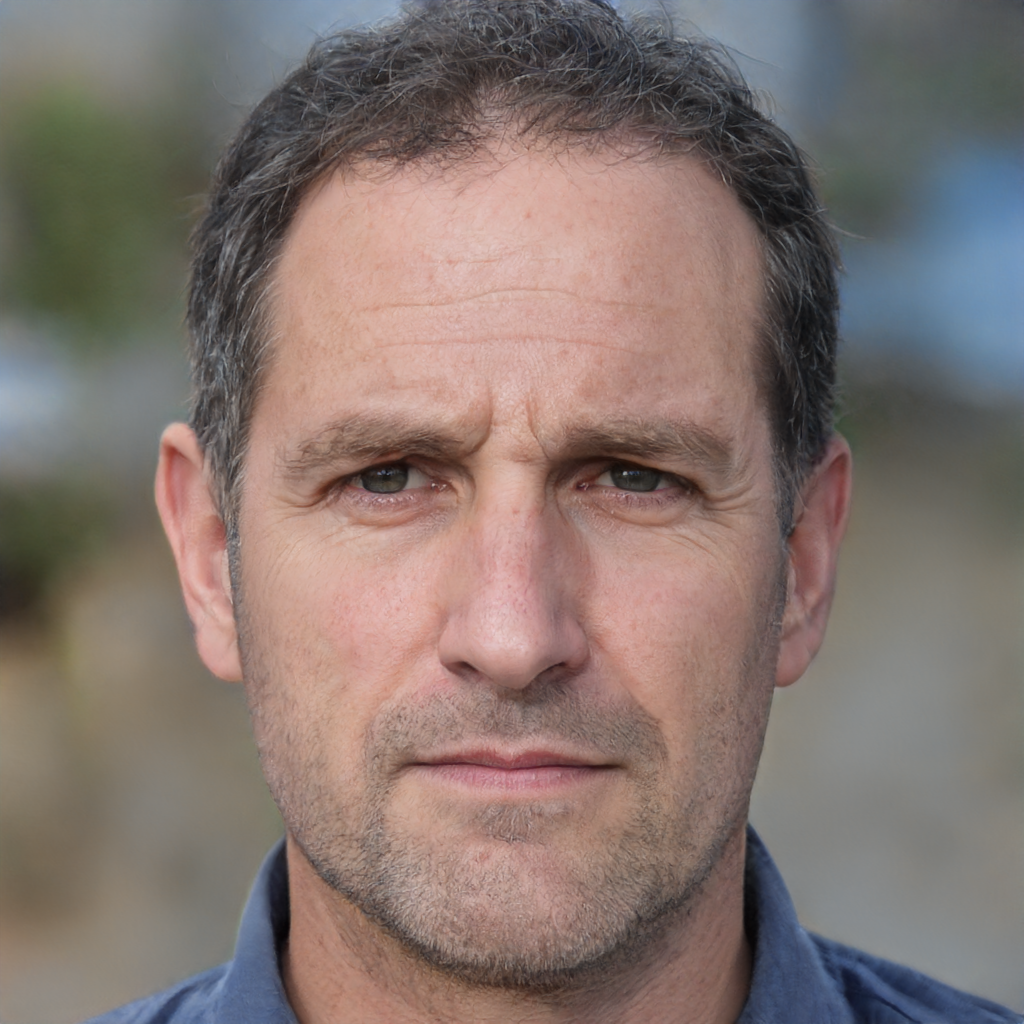

In [66]:
batch["image"][0]

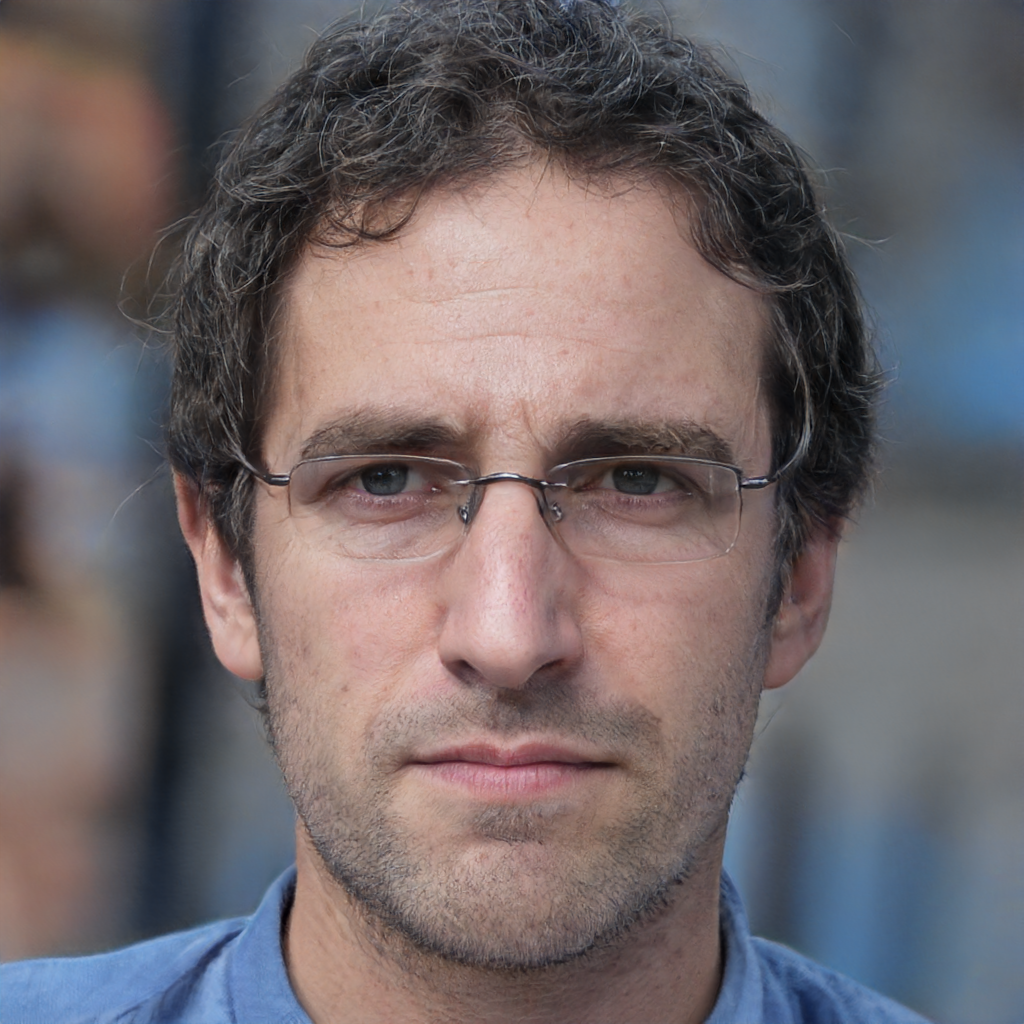

In [67]:
moved_z = lelsd.move_latent_codes(batch['z'].view(1, 8, 512), 0, alpha=7).squeeze()
moved_batch = sample_generator.generate_batch_from_z(moved_z, return_image=True)
moved_batch["image"][0]

# Debug Cells

In [ ]:
batch = sample_generator.generate_batch(seed=1, requires_grad=True, return_image=True)

In [ ]:
batch['raw_image'].size()

torch.Size([8, 3, 1024, 1024])

In [ ]:
upsample = torch.nn.Upsample(scale_factor=7)
average_pool = torch.nn.AvgPool2d(kernel_size=1024 // 32)
image_input = average_pool(upsample(batch['raw_image']))

In [ ]:
image_features = clip_model.encode_image(image_input).float().to(device)
image_features /= image_features.norm(dim=-1, keepdim=True)

In [ ]:
text_token = clip.tokenize("a person with glasses").to(device)
text_features = clip_model.encode_text(text_token).float().to(device)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [ ]:
similarity = torch.matmul(text_features, image_features.t())

In [ ]:
(1 - similarity).mean()

tensor(0.7726, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
similarity.view(batch_size, -1)

torch.Size([1, 8])